In [2]:
# ==============================================
# ✅ Apple Stock Price Prediction (Final Notebook)
# Combines classical ARIMA + enhanced LSTM modeling
# ==============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [9]:
import pandas as pd

df = pd.read_csv("AAPL.csv")
print(df.columns)
df.head()


Index(['symbol', 'date', 'close', 'high', 'low', 'open', 'volume', 'adjClose',
       'adjHigh', 'adjLow', 'adjOpen', 'adjVolume', 'divCash', 'splitFactor'],
      dtype='object')


,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2020-07-29 00:00:00+00:00,380.16,380.9200,374.85,375.000,22582314,92.391590,92.576295,91.101082,91.137537,90329256,0.0,1.0
1,AAPL,2020-07-30 00:00:00+00:00,384.76,385.1900,375.07,376.750,39532505,93.509543,93.614048,91.154549,91.562846,158130020,0.0,1.0
2,AAPL,2020-07-31 00:00:00+00:00,425.04,425.6600,403.30,411.535,93573867,103.298930,103.449611,98.015383,100.016764,374295468,0.0,1.0
3,AAPL,2020-08-03 00:00:00+00:00,435.75,446.5457,431.57,432.800,77037847,105.901818,108.525534,104.885938,105.184869,308151388,0.0,1.0
4,AAPL,2020-08-04 00:00:00+00:00,438.66,443.1600,433.55,436.530,43198092,106.609045,107.702696,105.367145,106.091384,172792368,0.0,1.0


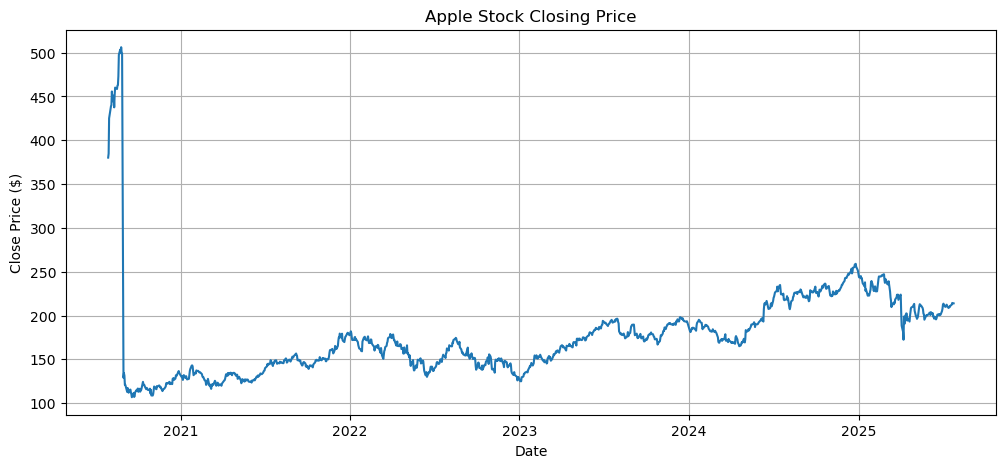

In [15]:
# ================================
# 📌 Step 1: Load and Visualize Data
# ================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# df = pdr.get_data_tiingo('AAPL', api_key=key)  ← Comment this line
df = pd.read_csv("AAPL.csv")
df.head()
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df = df[['close']].dropna()

plt.figure(figsize=(12, 5))
plt.plot(df['close'])
plt.title("Apple Stock Closing Price")
plt.xlabel("Date")
plt.ylabel("Close Price ($)")
plt.grid(True)
plt.show()


In [19]:
# ================================
# 📌 Step 2: Stationarity Check (ADF Test)
# ================================
result = adfuller(df['close'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] > 0.05:
    print("Series is likely non-stationary. Differencing required.")
else:
    print("Series is likely stationary.")

ADF Statistic: -5.886506363743579
p-value: 2.992888093243715e-07
Series is likely stationary.


C:\Users\Asus\Downloads\Telegram Desktop\anaconda installation\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Asus\Downloads\Telegram Desktop\anaconda installation\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Asus\Downloads\Telegram Desktop\anaconda installation\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Asus\Downloads\Telegram Desktop\anaconda installation\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: Use

ARIMA RMSE: 9.761850518944103
ARIMA MAE: 8.248114289049166


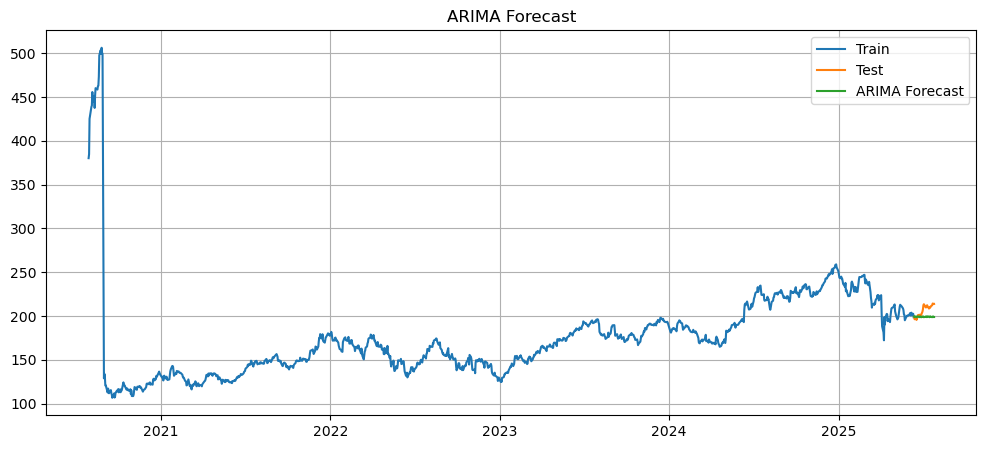

In [20]:
# ================================
# 📌 Step 4: ARIMA Model
# ================================
train = df.iloc[:-30]
test = df.iloc[-30:]

model_arima = ARIMA(train, order=(5, 1, 2))
model_fit = model_arima.fit()
forecast = model_fit.forecast(steps=30)

rmse = mean_squared_error(test, forecast, squared=False)
mae = mean_absolute_error(test, forecast)
print("ARIMA RMSE:", rmse)
print("ARIMA MAE:", mae)

plt.figure(figsize=(12, 5))
plt.plot(train.index, train['close'], label="Train")
plt.plot(test.index, test['close'], label="Test")
plt.plot(test.index, forecast, label="ARIMA Forecast")
plt.legend()
plt.title("ARIMA Forecast")
plt.grid(True)
plt.show()

C:\Users\Asus\Downloads\Telegram Desktop\anaconda installation\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 6.2311e-04 - val_loss: 4.9104e-04
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 5.2320e-04 - val_loss: 4.7388e-04
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 5.3489e-04 - val_loss: 5.7585e-04
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 4.6450e-04 - val_loss: 4.6804e-04
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 4.6917e-04 - val_loss: 4.3993e-04
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.9711e-04 - val_loss: 4.6674e-04
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 4.0359e-04 - val_loss: 4.1250e-04
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 3.7609e-04 - val_loss: 5.2703e-04
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 3.6375e-04 - val_loss: 4.2056e-04
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 3.1737e-04 - val_

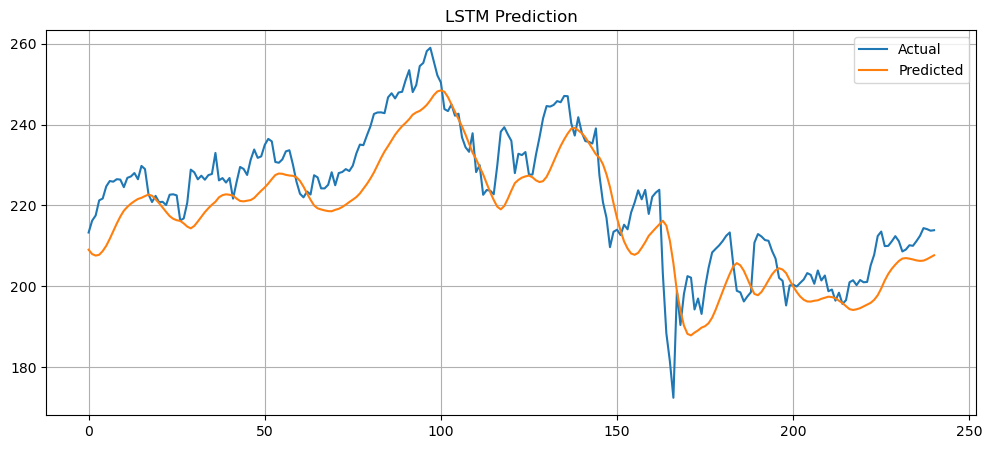

LSTM RMSE: 9.047694042032216
LSTM MAE: 7.431095859638388


C:\Users\Asus\Downloads\Telegram Desktop\anaconda installation\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [22]:
# ================================
# 📌 Step 5: LSTM Deep Learning Model
# ================================
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[['close']])

SEQ_LEN = 50

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(df_scaled, SEQ_LEN)
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

model_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LEN, 1)),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, verbose=1)

preds = model_lstm.predict(X_test)
preds_rescaled = scaler.inverse_transform(preds)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(12,5))
plt.plot(y_test_rescaled, label="Actual")
plt.plot(preds_rescaled, label="Predicted")
plt.title("LSTM Prediction")
plt.legend()
plt.grid(True)
plt.show()

lstm_rmse = mean_squared_error(y_test_rescaled, preds_rescaled, squared=False)
lstm_mae = mean_absolute_error(y_test_rescaled, preds_rescaled)
print("LSTM RMSE:", lstm_rmse)
print("LSTM MAE:", lstm_mae)



📊 Model Performance Comparison:
----------------------------------------
ARIMA RMSE: 9.7619
ARIMA MAE : 8.2481
LSTM  RMSE: 9.0477
LSTM  MAE : 7.4311


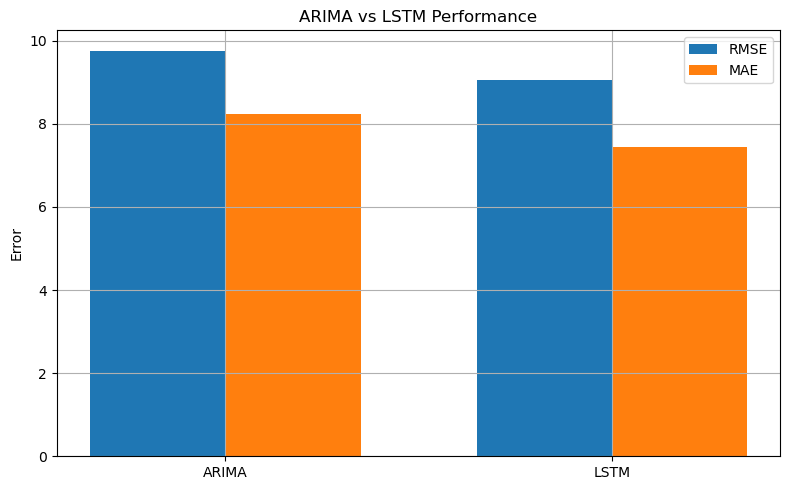


✅ LSTM performed better than ARIMA based on RMSE.


In [23]:
# ================================
# 📌 Step 6: Compare ARIMA vs LSTM
# ================================

print("\n📊 Model Performance Comparison:")
print("-" * 40)
print(f"ARIMA RMSE: {rmse:.4f}")
print(f"ARIMA MAE : {mae:.4f}")
print(f"LSTM  RMSE: {lstm_rmse:.4f}")
print(f"LSTM  MAE : {lstm_mae:.4f}")

# Bar Plot for RMSE Comparison
plt.figure(figsize=(8, 5))
models = ['ARIMA', 'LSTM']
rmse_vals = [rmse, lstm_rmse]
mae_vals = [mae, lstm_mae]

x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, rmse_vals, width, label='RMSE')
plt.bar(x + width/2, mae_vals, width, label='MAE')

plt.ylabel('Error')
plt.title('ARIMA vs LSTM Performance')
plt.xticks(x, models)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Best model decision
if lstm_rmse < rmse:
    print("\n✅ LSTM performed better than ARIMA based on RMSE.")
else:
    print("\n✅ ARIMA performed better than LSTM based on RMSE.")
